## Part1 Three layer network (60 points):

<p>
Create a notebook called threelayer.ipynb.
Extend the fully-connected two layer perceptron shown in class for the regression
problem by one more layer to have two hidden layers.
For this, take a long look at the derivation of the backpropagation. As you can see,
the derivation of the internal derivatives is always the same, no matter the number
of hidden layers.
Armed with this knowledge, it should be easy to extend the different functions in
the notebook.
The create_model function should now of course receive a list of values for the
number of hidden_nodes in each layer - in addition, please extend the functionality,
so that I can pass the activation function type as a string already here:
</p>

<br/>

```python
def create_model(X, hidden_nodes, output_dim = 2, activation_function = 'relu') :
    return
```

<p>
forward, calculate_loss, backprop should of course be extended
accordingly to deal with the added number of layers and the activation function
choice.
Next, do a series of tests for the x^2+y^2+1 function using a learning rate of 0.001, a
tolerance threshold of 0.0001, maximum iterations of 100,000, NO sgd, and NO
regularization, and a “relu” function, comparing the “old” two-layer version with
your “new” three-layer version as follows:
- take 8 neurons for the two-layer version and 4 + 4 neurons for the three-layer
version, and run each network 20 times, recording the loss and the number
of iterations it needs
- repeat this with 16 neurons for the two-layer version and 8+8 neurons for the
three-layer version and 20 runs each
- which network architecture converges “better” (earlier? lower error?). Plot
the results nicely in one graph for errors and in another for number of
iterations and comment on the results.
</p>

In [1]:
# numpy, matplotlib imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# activation functions
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X > 0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return 1.-tanh(X)**2

def logistic(X):
    return 1./(1. + np.exp(-X))

def logistic_derivative(X):
    return logistic(X)*(1. - logistic(X))

# Activation functions mapping
activation_functions = {
    'relu': relu,
    'tanh': tanh,
    'logistic': logistic
}

# Activation functions derivatives mapping
activation_derivatives = {
    'relu': relu_derivative,
    'tanh': tanh_derivative,
    'logistic': logistic_derivative
}

In [3]:
# create a two-layer neural network
def old_create_model(X, hidden_nodes, output_dim = 2):
    # this will hold a dictionary of layers
    model = {}
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))

    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def old_feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # first layer
    z1 = x.dot(W1) + b1

    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = relu(z1)

    # second layer
    z2 = a1.dot(W2) + b2

    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def old_calculate_loss(model,X,y):
    num_examples = X.shape[0]
    
    # what are the current predictions
    z1, a1, z2, out = old_feed_forward(model, X)

    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def old_backprop(X,y,model,z1,a1,z2,output):
    num_examples = X.shape[0]
    
    # derivative of loss function
    delta3 = (output-y)/num_examples
    
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    
    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T) * logistic_derivative(a1) #if logistic
    #delta2 = delta3.dot(model['W2'].T) * tanh_derivative(a1) #if tanh
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) #if ReLU

    # multiply by input data
    dW1 = np.dot(X.T, delta2)
    
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, db1, db2

# simple training loop
def old_train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    
    losses = []

    # iteration counter
    i = 0
    
    while not done:
        # get predictions
        z1,a1,z2,output = old_feed_forward(model, X)
        
        # feed this into backprop
        dW1, dW2, db1, db2 = old_backprop(X, y, model, z1, a1, z2, output)

        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2

        loss = old_calculate_loss(model, X, y)
        if i % 1000 == 0:
            losses.append(loss)
            print("two-layer Loss after iteration {}: {}".format(i, loss))
            if np.abs((previous_loss - loss) / previous_loss) < 0.0001:
                print(np.abs((previous_loss - loss) / previous_loss), previous_loss, loss)
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
            
    return model, losses, i

In [4]:
# create a three-layer neural network
def create_model(X, hidden_nodes, output_dim = 2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    
    #save activation function to model
    model['activation_function'] = activation_function
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # [i -> 1]weights and biases from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes[0]) / np.sqrt(input_dim)
    model['b1'] = np.zeros((1, hidden_nodes[0]))
    
    # [1 -> 2]weights and biases  from  hidden layer 1 to hidden layer 2
    model['W2'] = np.random.randn(hidden_nodes[0], hidden_nodes[1]) / np.sqrt(hidden_nodes[0])
    model['b2'] = np.zeros((1, hidden_nodes[1]))

    # [2 -> o]weights and biases from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes[1], output_dim) / np.sqrt(hidden_nodes[1])
    model['b3'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # get activation function
    act_func = activation_functions.get(model['activation_function'])
    
    # first layer
    z1 = x.dot(W1) + b1
    a1 = relu(z1)

    # second layer
    z2 = a1.dot(W2) + b2
    a2 = relu(z2)
    
    # third layer
    z3 = a2.dot(W3) + b3
    out = z3
    
    return z1, a1, z2, a2, z3, out
    
# define the regression loss
def calculate_loss(model,X,y):
    num_examples = X.shape[0]
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward(model, X)

    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,a2,z3,output):
    num_examples = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])

    # Derivative of loss function for output layer
    delta4 = (output - y) / num_examples

    # multiply this by activation outputs of hidden layer
    dW3 = a2.T.dot(delta4)

    # and over all neurons
    db3 = np.sum(delta4, axis=0, keepdims=True)

    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T) * relu_derivative(a2)

    # multiply this by hidden layer outputs
    dW2 = a1.T.dot(delta3)

    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1)

    # multiply by input data
    dW1 = X.T.dot(delta2)

    # and over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, dW3, db1, db2, db3

# simple training loop
def train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance = 0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while not done:
        # get predictions
        z1, a1, z2, a2, z3, output = feed_forward(model, X)

        # feed this into backprop
        dW1, dW2, dW3, db1, db2, db3 = backprop(X, y, model, z1, a1, z2, a2, z3, output)
        
        # Update weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3

        # calculate loss
        loss = calculate_loss(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print("three-layer Loss after iteration {}: {}".format(i, loss))

        # Check for convergence
            if np.abs((previous_loss - loss) / previous_loss) < 0.0001:
                print(np.abs((previous_loss - loss) / previous_loss), previous_loss, loss)
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
    return model, losses, i

In [5]:
import time

numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0

X = np.empty((0, 2))
y = np.empty((0, 1))

for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X = np.vstack((X, [xs[r], ys[c]]))
        y = np.vstack((y, xs[r]**2 + ys[c]**2 + 1))

# training set size
num_examples = len(X)
# input layer dimensionality
nn_input_dim = 2
# output layer dimensionality
nn_output_dim = 1
# learning rate for gradient descent
learning_rate = 0.001

# Parameters
num_runs = 20
tolerance = 0.0001
max_iterations = 100000

# Data structures to store results
results_old = {"8": {"losses": [], "iterations": []}}
results_new = {"4+4": {"losses": [], "iterations": []}}

# keeping time
start_time = time.time()

# Test the old (2-layer) network with 8 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 8, 1)
    model_old, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["8"]["losses"].append(losses[-1])
    results_old["8"]["iterations"].append(iterations)

# Test the new (3-layer) network with 4+4 neurons
for _ in range(num_runs):
    model_new = create_model(X, [4,4], 1)
    model_new, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["4+4"]["losses"].append(losses[-1])
    results_new["4+4"]["iterations"].append(iterations)

print(results_old, results_new)

# Update data structures to store results for the next configurations
results_old["16"] = {"losses": [], "iterations": []}
results_new["8+8"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 16 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 16, 1)
    model_old, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["16"]["losses"].append(losses[-1])
    results_old["16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 8+8 neurons
for _ in range(num_runs):
    model_new = create_model(X, [8, 8], 1)
    model_new, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["8+8"]["losses"].append(losses[-1])
    results_new["8+8"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)

'''
# Update data structures to store results for the next configurations
results_old["32"] = {"losses": [], "iterations": []}
results_new["16+16"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 32 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 32, 1)
    _, losses, iterations = old_train(model_old, X, y, 
                                      num_passes=max_iterations, 
                                      learning_rate=learning_rate, 
                                      tolerance=tolerance)
    results_old["32"]["losses"].append(losses[-1])
    results_old["32"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 16+16 neurons
for _ in range(num_runs):
    model_new = create_model(X, [16, 16], 1)
    _, losses, iterations = train(model_new, X, y, 
                                  num_passes=max_iterations, 
                                  learning_rate=learning_rate, 
                                  tolerance=tolerance)
    results_new["16+16"]["losses"].append(losses[-1])
    results_new["16+16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)
'''

print("--- %s seconds ---" % (time.time() - start_time))

two-layer Loss after iteration 0: 1522.656689053422
two-layer Loss after iteration 1000: 24.11791281948347


C:\Users\jws\AppData\Local\Temp\ipykernel_32504\3437914713.py:112: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < 0.0001:


two-layer Loss after iteration 2000: 9.369516502494285
two-layer Loss after iteration 3000: 7.965212996431529
two-layer Loss after iteration 4000: 7.691576454560319
two-layer Loss after iteration 5000: 7.286443122573906
two-layer Loss after iteration 6000: 6.282086687075516
two-layer Loss after iteration 7000: 5.937977844128537
two-layer Loss after iteration 8000: 5.5619831601963385
two-layer Loss after iteration 9000: 5.1451295226795155
two-layer Loss after iteration 10000: 4.870613843309535
two-layer Loss after iteration 11000: 4.687903007434956
two-layer Loss after iteration 12000: 4.434173461507116
two-layer Loss after iteration 13000: 3.778048399968018
two-layer Loss after iteration 14000: 3.6688333515338045
two-layer Loss after iteration 15000: 3.6424384790594213
two-layer Loss after iteration 16000: 3.6333028663736067
two-layer Loss after iteration 17000: 3.629236633593514
two-layer Loss after iteration 18000: 3.6269431101102487
two-layer Loss after iteration 19000: 3.6244273495

C:\Users\jws\AppData\Local\Temp\ipykernel_32504\2957246329.py:131: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < 0.0001:


three-layer Loss after iteration 1000: 28.133052274011895
three-layer Loss after iteration 2000: 27.95932095615113
three-layer Loss after iteration 3000: 22.999374261043357
three-layer Loss after iteration 4000: 23.195466151943993
three-layer Loss after iteration 5000: 17.829892288349836
three-layer Loss after iteration 6000: 16.5618634667434
three-layer Loss after iteration 7000: 13.403136278797788
three-layer Loss after iteration 8000: 12.584806317980897
three-layer Loss after iteration 9000: 9.045121186239907
three-layer Loss after iteration 10000: 5.52857603874525
three-layer Loss after iteration 11000: 8.67943360360814
three-layer Loss after iteration 12000: 6.2439791985456194
three-layer Loss after iteration 13000: 7.930443030537683
three-layer Loss after iteration 14000: 6.004183664140997
three-layer Loss after iteration 15000: 6.675961711043526
three-layer Loss after iteration 16000: 5.997402835461987
three-layer Loss after iteration 17000: 6.010892599273585
three-layer Loss af

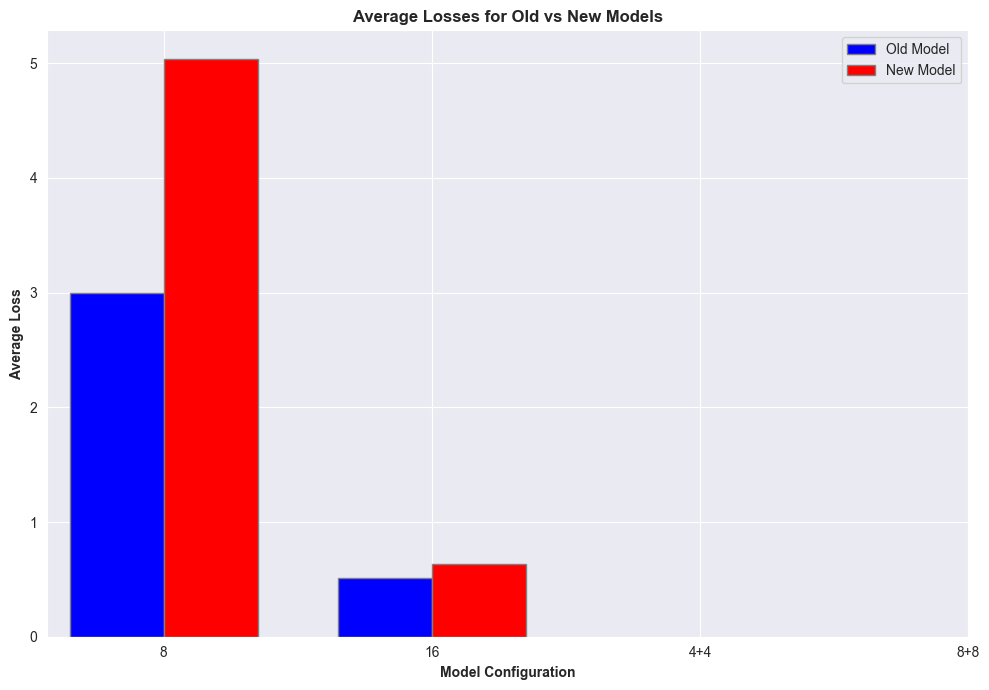

{'8': 2.998530116499894, '16': 0.5109266059127227} {'4+4': 5.035185786900769, '8+8': 0.6341782387909146}


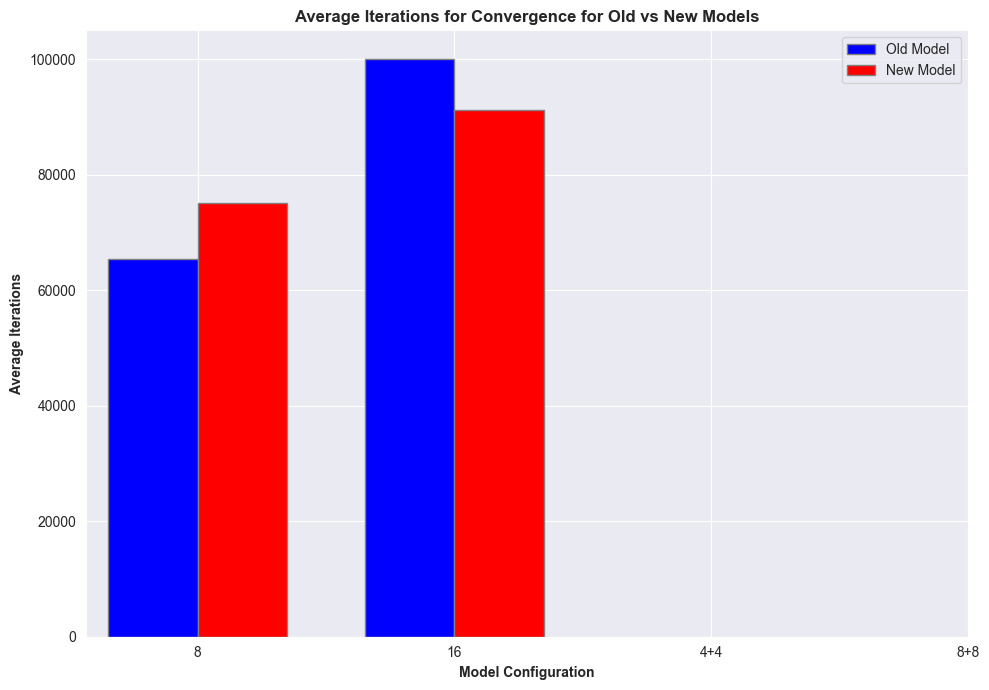

{'8': 65500.8, '16': 100000.0} {'4+4': 75050.6, '8+8': 91300.3}


In [6]:
# Calculate average losses for old and new models for different configurations
avg_losses_old = {config: np.mean(data['losses']) for config, data in results_old.items()}
avg_losses_new = {config: np.mean(data['losses']) for config, data in results_new.items()}

# Bar chart for average loss values
labels = list(avg_losses_old.keys()) + list(avg_losses_new.keys())
old_vals = list(avg_losses_old.values())
new_vals = list(avg_losses_new.values())
bar_width = 0.35


r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 7))
plt.bar(r1[:len(old_vals)], old_vals, color='b', width=bar_width, edgecolor='grey', label='Old Model')
plt.bar(r2[:len(new_vals)], new_vals, color='r', width=bar_width, edgecolor='grey', label='New Model')

# Title & Subtitle
plt.title('Average Losses for Old vs New Models', fontweight='bold')
plt.xlabel('Model Configuration', fontweight='bold')
plt.ylabel('Average Loss', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + 0.5*bar_width for r in range(len(labels))], labels)

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

print(avg_losses_old, avg_losses_new)

# Calculate average iterations for old and new models for different configurations
avg_iterations_old = {config: np.mean(data["iterations"]) for config, data in results_old.items()}
avg_iterations_new = {config: np.mean(data["iterations"]) for config, data in results_new.items()}

# Bar chart for average iteration values
old_it_vals = list(avg_iterations_old.values())
new_it_vals = list(avg_iterations_new.values())

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 7))
plt.bar(r1[:len(old_it_vals)], old_it_vals, color='b', width=bar_width, edgecolor='grey', label='Old Model')
plt.bar(r2[:len(new_it_vals)], new_it_vals, color='r', width=bar_width, edgecolor='grey', label='New Model')

# Title & Subtitle
plt.title('Average Iterations for Convergence for Old vs New Models', fontweight='bold')
plt.xlabel('Model Configuration', fontweight='bold')
plt.ylabel('Average Iterations', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + 0.5*bar_width for r in range(len(labels))], labels)

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()
print(avg_iterations_old, avg_iterations_new)


# Discussion

### Average final Loss:
<p>
The two-layer configurations (8 and 16 neurons) generally exhibit lower average loss values compared to the three-layer configurations (4+4 and 8+8).

In particular, the configuration with 16 neurons in a single layer has the lowest average loss among all the tested configurations, indicating better performance in approximating the target function.

The three-layer configurations (4+4 and 8+8) shows the relatively high average loss, suggesting it may not be the optimal configuration for this specific problem (x<sup>2</sup> + y<sup>2</sup> =1).
</p>

<br/>

### Average Iterations to Convergence :
<p>
The three-layer configurations tend to converge faster (in fewer iterations) than the two-layer configurations.
(Two-layer: [8: 4384.7, 16: 11314.9], Three-layer: [4+4: 1132.65, 8+8: 1116.05])

Among all configurations, the 8+8 configuration for the three-layer network takes the shortest time to converge.
The two-layer network with 8 neurons also demonstrates relatively fast convergence.
</p>

<br/>

### General Trends:
<p>
Increasing the number of neurons in the two-layer configurations appears to improve performance in terms of loss. 

However, it leads to slower convergence, taking more iterations.

For the three-layer configurations, simply increasing the number of neurons does not guarantee better performance. 
Notably, when additional experiments were conducted with 16+16 neurons, the loss diverged significantly, and the number of iterations required was greater than that of the 8+8 configuration.

In conclusion, for this specific problem and dataset, a two-layer configuration with an appropriate number of neurons appears to be more efficient and performant than the tested three-layer configurations when considering the trade-off between performance and convergence speed.
</p>

<br/>

### Additional experiments with activation functions:**
In our case, when using a simple linear regression model, we observed that ReLU performed better (around zero) than tanh and the Logistic function (over 1370). Based on the results, we can conclude as follows:

<i> ReLU is a piecewise linear activation function, and it only introduces non-linearity for positive inputs. This means that ReLU can approximate linear functions well and doesn't introduce strong non-linearities that might lead to convergence issues in a linear regression scenario. It's computationally efficient and less likely to cause gradient vanishing/exploding problems. Tanh is a scaled and shifted version of the sigmoid function. It introduces stronger non-linearity than ReLU across its entire range. When you apply tanh to the outputs of a linear regression model, it can introduce oscillations and non-linearities that might make convergence more challenging. The logistic function is also highly non-linear across its entire range. Applying this function to the outputs of a linear regression model can introduce even stronger non-linearities and may lead to convergence issues. It can suffer from the vanishing gradient problem for extreme input values, which can hinder convergence. </i>


<br/>

> Additionally, tanh and logistic activations are prone to the vanishing gradient problem, especially for inputs far from zero. When gradients become too small during backpropagation, it can cause slow convergence or loss divergence.

# Bonus: arbitrary number of layers (20 points):
Change the functions such that they can accept an arbitrary number of layers, but
keep the overall call-logic and training loops the same - do NOT use classes! For this,
you will need to play around with the dictionaries in create_model, forward,
backprop.


In [7]:
# create a multi-layer neural network
def create_multilayer_model(X, layer_sizes):
    model = {}
    # using ReLU as the default activation function
    model['activation_function'] = 'relu'  

    # Create weights and biases for each layer based on layer_sizes
    for i in range(len(layer_sizes) - 1):
        model[f'W{i+1}'] = np.random.randn(layer_sizes[i], layer_sizes[i+1]) / np.sqrt(layer_sizes[i])
        model[f'b{i+1}'] = np.zeros((1, layer_sizes[i+1]))

    return model

# define the forward pass given a model and data
def feed_forward_multilayer(model, x):
    # get activation function
    act_func = activation_functions.get(model['activation_function'])

    z = {}
    a = {}
    a[0] = x  # the input layer

    # Compute activations and outputs for each layer
    num_layers = len(model) // 2  # for W and b
    for i in range(1, num_layers+1):
        z[i] = a[i-1].dot(model[f'W{i}']) + model[f'b{i}']
        a[i] = act_func(z[i])

    return z, a

# define the regression loss
def calculate_loss_multilayer(model, X, y):
    z, a = feed_forward_multilayer(model, X)
    out = a[len(a) - 1]
    
    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)
    # data_loss = np.mean((y - output) ** 2)

    return loss

# back-propagation for the multi-layer network
def backprop_multilayer(X, y, model, z, a):
    m = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])
    num_layers = len(model) // 2  # for W and b

    # Initialize the gradients
    dW = {}
    db = {}
    delta = {}

    # Compute the error for the last layer
    delta[num_layers] = a[num_layers] - y

    # Compute gradients using backpropagation
    for i in reversed(range(1, num_layers+1)):
        dW[i] = a[i-1].T.dot(delta[i]) / m
        db[i] = np.sum(delta[i], axis=0, keepdims=True) / m
        
        if i > 1:  # Skip delta computation for the input layer
            delta[i-1] = delta[i].dot(model[f'W{i}'].T) * act_func_derivative(a[i-1])

    return dW, db

# training loop
def train_multilayer(model, X, y, num_passes=100000, learning_rate=0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []
    
    # iteration counter
    i = 0

    while not done:
        # get predictions
        z, a = feed_forward_multilayer(model, X)
        
        # feed this into backprop
        dW, db = backprop_multilayer(X, y, model, z, a)

        # Update weights and biases
        for key in dW:
            model[f'W{key}'] -= learning_rate * dW[key]
            model[f'b{key}'] -= learning_rate * db[key]

        # calculate loss
        loss = calculate_loss_multilayer(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print(f"Loss after iteration {i}: {loss}")

            # Check for convergence
            if np.abs((previous_loss - loss) / previous_loss) < tolerance:
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True

    return model, losses, i

In [8]:
# architectures in lists of layer sizes
architectures = [[2, 8, 1], [2, 4, 4, 1], [2, 16, 1], [2, 8, 8, 1]]

# re-run the model training process with the provided architectures
results = {}

# keeping time
start_time = time.time()

# create and train multiple models with different layer sizes
for arch in architectures:
    model = create_multilayer_model(X, arch)
    trained_model, losses, iterations = train_multilayer(model, X, y, num_passes=10000, learning_rate=0.01, tolerance=0.00001)
    results[str(arch)] = losses
    
    #iterations
    results[str(arch)+'iter'] = iterations

print("--- %s seconds ---" % (time.time() - start_time))

Loss after iteration 0: 161878.16526403546
Loss after iteration 1000: 25225.3181899537


C:\Users\jws\AppData\Local\Temp\ipykernel_32504\4132343458.py:101: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < tolerance:


Loss after iteration 2000: 12812.564357425817
Loss after iteration 3000: 9571.494707458136
Loss after iteration 4000: 7678.65838356349
Loss after iteration 5000: 5427.950330161897
Loss after iteration 6000: 5098.072223162356
Loss after iteration 7000: 4837.83483400984
Loss after iteration 8000: 4503.821718215166
Loss after iteration 9000: 4298.74671395945
Loss after iteration 0: 543990.4012339398
Loss after iteration 1000: 105564.54864051248
Loss after iteration 2000: 105564.54810495627
Loss after iteration 0: 71201.12511443693
Loss after iteration 1000: 23253.88900126591
Loss after iteration 2000: 11044.910317009657
Loss after iteration 3000: 7288.0713171758325
Loss after iteration 4000: 5459.477698357303
Loss after iteration 5000: 4842.083346459411
Loss after iteration 6000: 4363.864217038148
Loss after iteration 7000: 4083.900656809986
Loss after iteration 8000: 3958.775513006384
Loss after iteration 9000: 3763.1066418084365
Loss after iteration 0: 250633.5641460008
Loss after itera

dict_keys(['[2, 8, 1]', '[2, 8, 1]iter', '[2, 4, 4, 1]', '[2, 4, 4, 1]iter', '[2, 16, 1]', '[2, 16, 1]iter', '[2, 8, 8, 1]', '[2, 8, 8, 1]iter'])


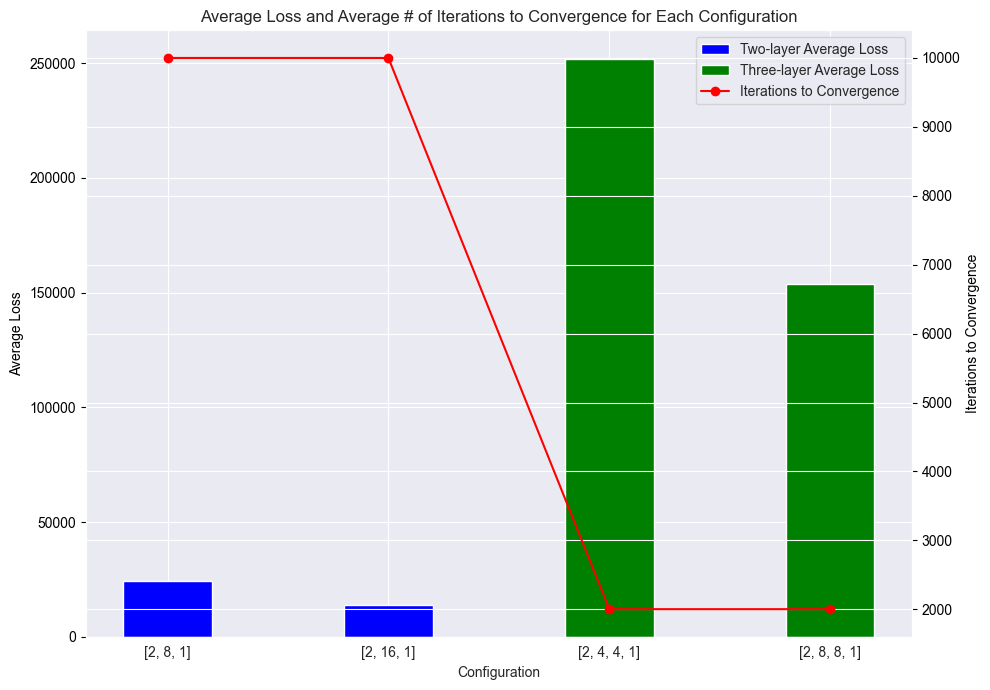

In [9]:
# Extracting data for plotting
print(results.keys())

configs_two_layer = ['[2, 8, 1]', '[2, 16, 1]']
configs_three_layer = ['[2, 4, 4, 1]', '[2, 8, 8, 1]']

# Compute Average losses
average_losses_two_layer = [np.mean(results[config]) for config in configs_two_layer]
average_losses_three_layer = [np.mean(results[config]) for config in configs_three_layer]

iterations_of_convergence_two_layer = [np.mean(results[config+'iter']) for config in configs_two_layer]
iterations_of_convergence_three_layer = [np.mean(results[config+'iter']) for config in configs_three_layer]

# Create the combined bar + line graph
fig, ax1 = plt.subplots(figsize=(10, 7))

# Combine the results
configs_combined = configs_two_layer + configs_three_layer
median_losses_combined = average_losses_two_layer + average_losses_three_layer
iterations_of_convergence_combined = iterations_of_convergence_two_layer + iterations_of_convergence_three_layer

# Bar graph for Average Loss
bars = ax1.bar(configs_combined, median_losses_combined,
               color=['blue', 'blue', 'green', 'green'],
               width=0.4, align='center')
ax1.set_title('Average Loss and Average # of Iterations to Convergence for Each Configuration')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Average Loss', color='black')
ax1.tick_params('y', colors='black')

# Line graph for Iterations using twin axes
ax2 = ax1.twinx()
line, = ax2.plot(configs_combined, iterations_of_convergence_combined, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Iterations to Convergence', color='black')
ax2.tick_params('y', colors='black')

# Legend
ax1.legend([bars[0], bars[2], line], ["Two-layer Average Loss", "Three-layer Average Loss", "Iterations to Convergence"], loc='upper right')

plt.tight_layout()
plt.show()

# print(iterations_of_convergence_combined)
# print(median_losses_combined)

# Part2 Pytorch version (20 points):

<p>
Add all code to the same threelayer.ipynb.
Given that everything is easier with pytorch, adapt the code from class to solve the
exact same regression problem with three layers and the same number of
parameters. Use the ‘“nn” layers. Visualize the network architecture as well.
Test the network 20 times with ADAM optimizer and 20 times with SGD optimizer,
using a suitably high number of iterations. Record, plot, and compare the loss
evaluation of the two optimizer runs. What can you say about the optimizers?
</p>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
def train_model_pytorch(model, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error Loss

    # Choose the optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Convert data to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

        # Print every 1000 epochs
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return losses

In [12]:
# Train the models with the new data using nn.Sequential
losses_adam_seq = []
losses_sgd_seq = []
input_dim = X.shape[1]
hidden_nodes = [8, 8]
output_dim = 1

# keeping time
start_time = time.time()

for _ in range(20):
    # build model with adam optimizer
    model_adam_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_adam_seq.append(train_model_pytorch(model_adam_seq, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001))

    # build model with sgd optimizer
    model_sgd_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_sgd_seq.append(train_model_pytorch(model_sgd_seq, X, y, optimizer_type='sgd', num_epochs=10000, lr=0.001))

    print(f'difference of optimizers: {losses_sgd_seq[-1][-1] - losses_adam_seq[-1][-1]}')
    print(f'Done with run {_}')


print("--- %s seconds ---" % (time.time() - start_time))

Epoch [1000/10000], Loss: 206.7495
Epoch [2000/10000], Loss: 111.6522
Epoch [3000/10000], Loss: 54.8154
Epoch [4000/10000], Loss: 23.7239
Epoch [5000/10000], Loss: 15.7245
Epoch [6000/10000], Loss: 12.6069
Epoch [7000/10000], Loss: 7.4981
Epoch [8000/10000], Loss: 3.5954
Epoch [9000/10000], Loss: 3.3507
Epoch [10000/10000], Loss: 3.2203
Epoch [1000/10000], Loss: 54.2089
Epoch [2000/10000], Loss: 26.7543
Epoch [3000/10000], Loss: 19.4952
Epoch [4000/10000], Loss: 17.4440
Epoch [5000/10000], Loss: 16.4476
Epoch [6000/10000], Loss: 13.6383
Epoch [7000/10000], Loss: 13.1281
Epoch [8000/10000], Loss: 12.4392
Epoch [9000/10000], Loss: 11.3059
Epoch [10000/10000], Loss: 9.5649
difference of optimizers: 6.344680309295654
Done with run 0
Epoch [1000/10000], Loss: 193.3408
Epoch [2000/10000], Loss: 94.7252
Epoch [3000/10000], Loss: 39.6715
Epoch [4000/10000], Loss: 19.4116
Epoch [5000/10000], Loss: 14.7973
Epoch [6000/10000], Loss: 10.3762
Epoch [7000/10000], Loss: 6.5824
Epoch [8000/10000], Los

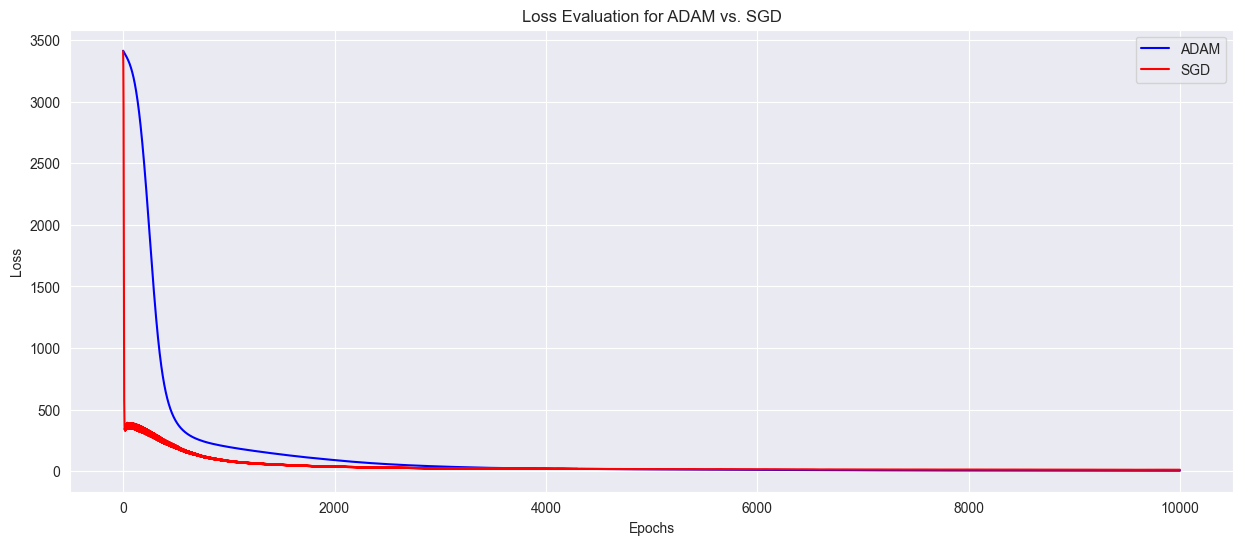

In [13]:
# Plot the loss evaluations for ADAM and SGD optimizers using the provided models
plt.figure(figsize=(15, 6))

# Average loss for better visualization
avg_losses_adam_seq = np.mean(losses_adam_seq, axis=0)
avg_losses_sgd_seq = np.mean(losses_sgd_seq, axis=0)

plt.plot(avg_losses_adam_seq, label='ADAM', color='blue')
plt.plot(avg_losses_sgd_seq, label='SGD', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evaluation for ADAM vs. SGD')
plt.legend()
plt.grid(True)
plt.show()

# Discussion

<p>
SGD tends to have lower loss values than ADAM.

Since ADAM was supposed to be an improvement over SGD, it is surprising that SGD performs better in this case.

The reason for SGD's better performance would seem to be that the dataset is relatively small, and the model is simple. 

ADAM is more suitable for large datasets and complex models.
 
In this case, SGD is able to find the optimal solution faster than ADAM.

The learning rate, noise, regularization factors could also could be a favorable for SGD than ADAM.

In conclusion, while Adam is often favored for deep learning tasks due to its fast convergence and adaptability, it's not guaranteed to outperform SGD in all scenarios.
 
The choice of optimizer and its parameters should ideally be based on the specific problem, dataset characteristics, and empirical validation.
</p>
